In [1]:
import pandas as pd
import numpy as np
from numpy import dot
from numpy.linalg import norm
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns
from functools import reduce
from scipy.spatial import distance
import pathlib
import os
from sklearn.decomposition import PCA
import json
import random
from random import sample

random.seed(30)

In [2]:
# Set data input folder
input_folder = "inputs"

# Set output folder, subfolder
output_folder = "outputs"
if not os.path.exists(output_folder):
    os.makedirs(output_folder, exist_ok=True)

In [3]:
### Load barcodes used in experiment
guides = pd.read_csv('../common_files/Barcodes.csv')
guide_list = list(guides['sgRNA'])

# Import the guide-level profiles
df_guide = pd.read_csv("inputs/20210422_6W_CP257_guide_normalized_feature_select_median_merged_ALLBATCHES___DMEM___ALLWELLS.csv.gz")
df_guide = df_guide[df_guide["Metadata_Foci_Barcode_MatchedTo_Barcode"].isin(guide_list)]
# Subset the nontargeting guide profiles 
df_nontargeting = df_guide.query("Metadata_Foci_Barcode_MatchedTo_GeneCode == 'nontargeting'")

In [4]:
whole_cell_hits_dict = {}
comp_spec_hits_dict = {}
non_hits_dict = {}
conditions = ['DMEM_1','DMEM_2','DMEM_3','DMEM_4','DMEM_5']
for condition in conditions:
    whole_cell_hits = pd.read_csv(f'inputs/HeLa_{condition}_plate_level_median_per_feat_sig_genes_5_fdr_whole_cell_hits.csv')
    comp_spec_hits = pd.read_csv(f'inputs/HeLa_{condition}_plate_level_median_per_feat_sig_genes_5_fdr_compartment_specific_hits.csv')
    all_hits = pd.concat([whole_cell_hits,comp_spec_hits])
    hit_list = list(comp_spec_hits.Gene) + list(whole_cell_hits.Gene)
    whole_cell_hit_list = list(whole_cell_hits.Gene)
    comp_spec_hit_list = list(comp_spec_hits.Gene)
    all_genes_list = list(df_guide.Metadata_Foci_Barcode_MatchedTo_GeneCode.unique())
    all_genes_list.remove("nontargeting")
    non_hit_list = [gene for gene in all_genes_list if gene not in hit_list]

    whole_cell_hits_dict[condition] = whole_cell_hit_list
    comp_spec_hits_dict[condition] = comp_spec_hit_list
    non_hits_dict[condition] = non_hit_list
    
    print(f'for condition {condition} there are {len(whole_cell_hit_list)} Whole cell hits')
    print(f'for condition {condition} there are {len(comp_spec_hit_list)} Compartment hits')
    print(f'for condition {condition} there are {len(non_hit_list)} Compartment hits')
    

for condition DMEM_1 there are 1039 Whole cell hits
for condition DMEM_1 there are 891 Compartment hits
for condition DMEM_1 there are 18463 Compartment hits
for condition DMEM_2 there are 1384 Whole cell hits
for condition DMEM_2 there are 1398 Compartment hits
for condition DMEM_2 there are 17611 Compartment hits
for condition DMEM_3 there are 1795 Whole cell hits
for condition DMEM_3 there are 1627 Compartment hits
for condition DMEM_3 there are 16971 Compartment hits
for condition DMEM_4 there are 2134 Whole cell hits
for condition DMEM_4 there are 2044 Compartment hits
for condition DMEM_4 there are 16215 Compartment hits
for condition DMEM_5 there are 2356 Whole cell hits
for condition DMEM_5 there are 2356 Compartment hits
for condition DMEM_5 there are 15681 Compartment hits


In [5]:
gene_list = list(df_guide.Metadata_Foci_Barcode_MatchedTo_GeneCode)
df_temp = df_guide.drop('Metadata_Foci_Barcode_MatchedTo_GeneCode',axis=1).set_index('Metadata_Foci_Barcode_MatchedTo_Barcode')
# Perform principal component analysis on hit list
pca = PCA()
pca.fit(df_temp)
x = list(pca.explained_variance_ratio_)
# Find principal component that represents 70% variation
PCA_lookup = {}
for i in range(len(x)):
    distance = abs(.9-sum(x[:i+1]))
    PCA_lookup[distance] = i 
component = PCA_lookup[min(PCA_lookup.keys())]+1
print (f'Principal component representing closest to 90% variation is {component}')
# Perform principal component analysis and select components representing 70% of variation in data
pca = PCA(n_components=component)
df_guide_pca = pd.DataFrame(pca.fit_transform(df_temp),index=df_temp.index)
df_guide_pca_updated = df_guide_pca.reset_index()
pca_feat_list = list(df_guide_pca_updated.columns)
feat_list = ['Metadata_Foci_Barcode_MatchedTo_GeneCode']
feat_list.extend(pca_feat_list)
df_guide_pca_updated["Metadata_Foci_Barcode_MatchedTo_GeneCode"] = gene_list
df_guide_pca_updated = df_guide_pca_updated[feat_list]
df_guide_pca_updated

Principal component representing closest to 90% variation is 721


,Metadata_Foci_Barcode_MatchedTo_GeneCode,Metadata_Foci_Barcode_MatchedTo_Barcode,0,1,2,3,4,5,6,7,...,711,712,713,714,715,716,717,718,719,720
0,A1BG,CAAGAGAAAGACCACGAGCA,-2.797839,-6.638351,3.732794,-5.500276,3.400353,-2.234676,1.326102,5.053755,...,0.079720,0.033480,0.206684,0.251004,-0.002461,0.197933,-0.347885,-0.219374,0.004931,0.039922
1,A1BG,CATCTTCTTTCACCTGAACG,4.223268,2.547329,-0.519613,-2.526660,-1.950841,-0.214483,2.180046,1.034041,...,-0.367500,-0.278417,0.164765,0.115409,0.614185,0.199095,0.005003,0.066241,0.385971,0.186258
2,A1BG,CTCCGGGGAGAACTCCGGCG,0.226131,7.664180,1.334145,0.852733,0.490193,-1.142523,-3.919489,2.274953,...,-0.427206,0.787757,-0.115288,0.119347,-0.425516,-0.352062,-0.129102,0.157178,1.015410,0.498693
3,A1BG,TGGAAGTCCACTCCACTCAG,4.121460,6.407549,4.803152,-0.593453,-3.772468,1.283582,-2.047281,0.690167,...,0.150874,-0.224175,-0.266424,-0.219084,-0.446646,-0.293895,0.031090,0.152051,-0.262706,-0.274841
4,A1CF,AGTTATGTTAGGTATACCCG,-0.356097,7.524270,-0.444434,-1.801940,-0.231022,1.885177,-0.823701,5.150096,...,-0.460253,0.436963,0.405628,-0.042185,0.057377,0.086388,-0.022723,0.112512,0.324239,-0.349584
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80797,nontargeting,TTTATGCATTTAATACGCCG,1.344141,1.089012,1.373800,-1.499881,-0.343863,-0.275255,-0.552219,0.419090,...,-0.029709,-0.036708,-0.033970,0.074210,0.018395,0.049315,-0.011096,-0.031589,0.042309,-0.017222
80798,nontargeting,TTTCTAGTTACTACTGGACG,0.748472,1.479106,0.429455,-2.093931,0.316832,-0.384918,-0.124140,0.508944,...,-0.016709,0.020809,-0.011484,0.046674,0.037502,0.008135,-0.061817,0.024453,-0.001611,0.058370
80799,nontargeting,TTTGGCAGTACCTTTTATTA,-0.086137,0.508386,0.346766,-2.673848,0.279349,0.144354,-0.572088,0.527859,...,0.060323,0.019919,0.007141,0.011320,0.040779,-0.003379,0.037810,-0.006381,0.017116,-0.012442
80800,nontargeting,TTTTACCTTGTTCACATGGA,-0.894496,1.648901,-0.633126,-1.322831,-0.078447,0.129657,-0.132439,0.788267,...,0.022892,-0.044445,0.014253,-0.086612,0.017108,0.042700,-0.009588,-0.041876,-0.033181,0.051922


In [6]:
def cosine_to_df(df_temp, cosine_array, i):
    cosine_list = cosine_array[i]
    gene_list = list(df_temp.index)
    cosine_df = pd.DataFrame(index=gene_list)
    cosine_df['cosine'] = cosine_list
    cosine_df = cosine_df.sort_values('cosine',ascending=False)   
    return cosine_df

def ap_from_cosine_df(cosine_df,gene,n=10):    
    #print(cosine_df.iloc[:20])
    index_list = list(cosine_df.index)
    boolean = [1 if  i == gene else 0 for i in index_list ]
    grades_list=[]
    for i in range(2,n+2):
        pre_grade = sum(boolean[1:i])/(i-1)
        grades_list.append(pre_grade*boolean[i-1])
    return sum(grades_list)/3

def calculate_map(df_guide, gene):
    df_temp = df_guide.query("Metadata_Foci_Barcode_MatchedTo_GeneCode == 'nontargeting' | Metadata_Foci_Barcode_MatchedTo_GeneCode == @gene")
    df_temp = df_temp.drop(['Metadata_Foci_Barcode_MatchedTo_Barcode'],axis=1)
    df_temp = df_temp.set_index("Metadata_Foci_Barcode_MatchedTo_GeneCode")
    ap_list = []
    cosine_array = cosine_similarity(df_temp)
    for guide in range(4):
        cosine_df = cosine_to_df(df_temp, cosine_array, guide)
        guide_ap = ap_from_cosine_df(cosine_df,gene,10)
        ap_list.append(guide_ap)
    return np.mean(ap_list)

In [7]:
# Plot hits summary for Fig 3A
import matplotlib as mpl
def plot_results(plot_dict,group):
    mpl.rc('axes', linewidth=0.7)
    mpl.rc('xtick', labelsize=14)
    mpl.rc('xtick', labelsize=14)
    
    fig, ax = plt.subplots(figsize=(7,5))
    colors = sns.color_palette('GnBu')[:8]
    hits_plot = pd.DataFrame({'Average_mAP':list(plot_dict.values())},
                             index = list(plot_dict.keys()))
    
    hits_plot.plot(kind='bar', 
                   stacked=True,
                   color=[colors[5]],
                   legend = 'reverse',
                   rot = 0,
                   fontsize= 14,
                   width = 0.5,
                   ax=ax)
    
    ax.set_title('',size=14) #Genes with significant signal above noise
    ax.set_ylabel('Average mAP',size=14)
    
    ax.bar_label(ax.containers[0],label_type='center',size=12,fmt='%0.2f',color="midnightblue")
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.legend(loc="upper left", bbox_to_anchor=(0.8,1),frameon=False, ncol=1, fontsize =14)
    fig.savefig(os.path.join(output_folder,f'HeLa_DMEM_average_mAP_{group}.png'),dpi = 300,bbox_inches='tight')
    plt.show()


In [8]:
# calculate mAP for Whole cell hits
map_list = []
for i in range(len(whole_cell_hit_list)):
    gene = whole_cell_hit_list[i]
    #print(f"Calculating mean average precision for gene: {gene}")
    gene_map = calculate_map(df_guide_pca_updated, gene)
    map_list.append(gene_map)
    
np.mean(map_list)

0.2754919753460713

for condition DMEM_1 average mAP for Whole cell hits = 0.44437267340900644
for condition DMEM_2 average mAP for Whole cell hits = 0.3816592978713644
for condition DMEM_3 average mAP for Whole cell hits = 0.3257563079394556
for condition DMEM_4 average mAP for Whole cell hits = 0.29329706304577435
for condition DMEM_5 average mAP for Whole cell hits = 0.2754919753460713


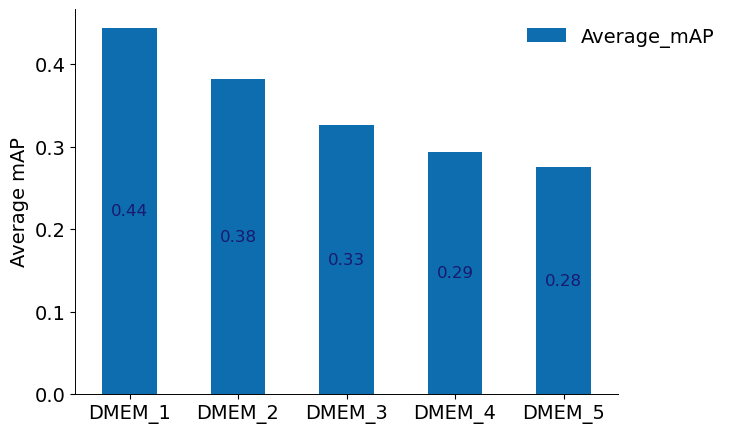

In [9]:
# calculate mAP for Whole cell hits
plot_whole_cell_hits_dict = {}
for condition in conditions:
    whole_cell_hit_list = whole_cell_hits_dict[condition]
    map_list = []
    for i in range(len(whole_cell_hit_list)):
        gene = whole_cell_hit_list[i]
        gene_map = calculate_map(df_guide_pca_updated, gene)
        map_list.append(gene_map)
    plot_whole_cell_hits_dict[condition] = np.mean(map_list)
    print(f'for condition {condition} average mAP for Whole cell hits = {np.mean(map_list)}')
plot_results(plot_whole_cell_hits_dict,'whole_cell_hits')

for condition DMEM_1 average mAP for Compartment hits = 0.13870862505121764
for condition DMEM_2 average mAP for Compartment hits = 0.0971634648136794
for condition DMEM_3 average mAP for Compartment hits = 0.07925833243903312
for condition DMEM_4 average mAP for Compartment hits = 0.06515313888112322
for condition DMEM_5 average mAP for Compartment hits = 0.05812213385165421


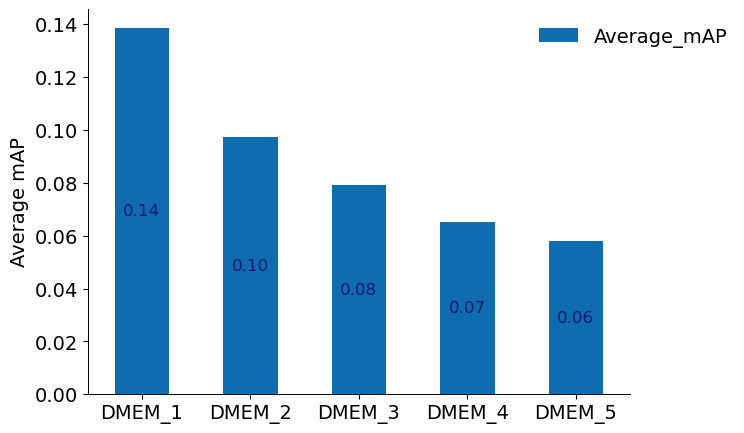

In [10]:
# calculate mAP for Compartment hits
plot_comp_spec_hits_dict = {}
for condition in conditions:
    comp_spec_hit_list = comp_spec_hits_dict[condition]
    map_list = []
    for i in range(len(comp_spec_hit_list)):
        gene = comp_spec_hit_list[i]
        gene_map = calculate_map(df_guide_pca_updated, gene)
        map_list.append(gene_map)
    plot_comp_spec_hits_dict[condition] = np.mean(map_list)
    print(f'for condition {condition} average mAP for Compartment hits = {np.mean(map_list)}')
plot_results(plot_comp_spec_hits_dict,'compartment_hits')

for condition DMEM_1 average mAP for non-hits = 0.029482389990907028
for condition DMEM_2 average mAP for non-hits = 0.02643660024593816
for condition DMEM_3 average mAP for non-hits = 0.02450887274557064
for condition DMEM_4 average mAP for non-hits = 0.022852729607277862
for condition DMEM_5 average mAP for non-hits = 0.02191385228779209


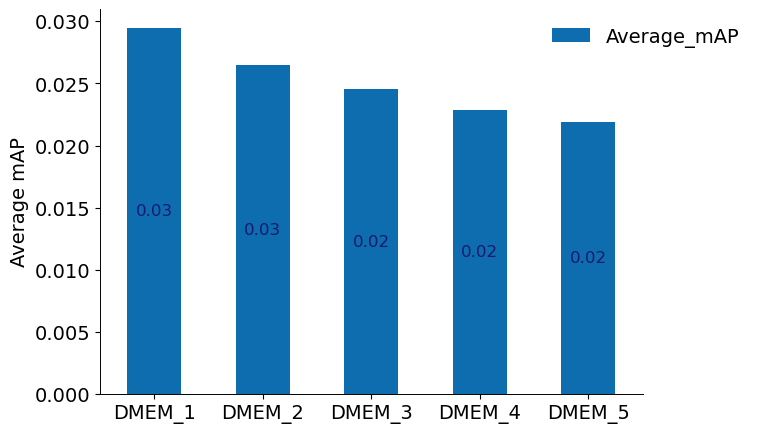

In [11]:
# calculate mAP for non_hits
plot_non_hits_dict = {}
for condition in conditions:
    non_hit_list = non_hits_dict[condition]
    map_list = []
    for i in range(len(non_hit_list)):
        gene = non_hit_list[i]
        gene_map = calculate_map(df_guide_pca_updated, gene)
        map_list.append(gene_map)
    plot_non_hits_dict[condition] = np.mean(map_list)
    print(f'for condition {condition} average mAP for non-hits = {np.mean(map_list)}')
plot_results(plot_non_hits_dict,'non_hits')